In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import shap
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier, MLPRegressor
from keras.models import Sequential, Model
from keras.layers import Dense,Activation,Dropout, Flatten, Concatenate, concatenate, Input, Lambda
# from keras.layers.embeddings import Embedding
from keras.layers.normalization import batch_normalization 
from keras.utils import np_utils
from tqdm import tqdm
import ipywidgets as widgets

2023-07-04 14:09:46.865233: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
def get_reshape(row):
    # print(row)
    return np.fromstring(row['grid'].replace('\n','')
                                    .replace('[','')
                                    .replace(']','')
                                    .replace('  ',' '), sep=' ').reshape(row['grid_rows'],row['grid_columns'])

def convert_obs(df):
    return df['observation'].apply(lambda x: 
                           np.fromstring(
                               x.replace('\n','')
                                .replace('[','')
                                .replace(']','')
                                .replace('  ',' '), sep=' '))

def gen_heatmap(df,f, ax):
    df = df.reset_index()
    x_array = df['x'].to_numpy()
    y_array =df['y'].to_numpy()
    grid = np.zeros((df['grid_rows'][0],df['grid_columns'][0]))
    for i, j in zip(y_array,x_array):
        grid[i,j]+=1
    heat =sns.heatmap(grid,cmap='viridis',alpha =0.6,zorder=2,ax=ax)
    my_image = mpimg.imread(f)
    # plt.imshow(my_image)
    plt.title(df['experiment'][0])
    ax.heat.imshow(my_image,aspect=heat.get_aspect(),extent= heat.get_xlim() + heat.get_ylim(),zorder=1)
    # plt.close()
    # return heat

def keras_classifier(n_inputs,n_outputs):
    model = Sequential()
    model.add(Dense(1000, input_dim= n_inputs, activation='relu'))
    model.add(Dense(500, activation='relu'))
    model.add(Dense(300, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    return model


In [12]:
df1 = pd.read_csv('./data/data.csv')
df = pd.read_csv('./data/data_policy_switching.csv')
df.describe()

,run,step,x,y,reward,grid_rows,grid_columns
count,3276.000000,3276.000000,3276.000000,3276.000000,3276.000000,3276.0,3276.0
mean,14.517399,13.215201,7.626374,7.782967,-0.263126,15.0,15.0
std,8.697144,7.979617,5.409821,5.097004,3.948028,0.0,0.0
min,0.000000,0.000000,0.000000,0.000000,-21.000000,15.0,15.0
25%,7.000000,6.000000,2.000000,4.000000,-1.000000,15.0,15.0
50%,14.000000,13.000000,8.000000,7.000000,-1.000000,15.0,15.0
75%,22.000000,20.000000,14.000000,14.000000,-1.000000,15.0,15.0
max,29.000000,28.000000,14.000000,14.000000,19.000000,15.0,15.0


In [13]:
# Modify the grid to be a correct numpy array representing the level
df1['grid'] = df1[['grid','grid_rows','grid_columns']].apply(lambda x: get_reshape(x),axis=1)
df['grid'] = df[['grid','grid_rows','grid_columns']].apply(lambda x: get_reshape(x),axis=1)

# format the observation space into numpy array
df1['observation'] = convert_obs(df1)
df['observation'] = convert_obs(df)

# Shuffle the data 
df1 = df1.sample(frac=1)
df = df.sample(frac=1)

# Shuffle the data 
df1 = df1.sample(frac=1)
df = df.sample(frac=1)

# Shuffle the data 
df1 = df1.sample(frac=1)
df = df.sample(frac=1)
df.head()

,experiment,level,run,step,x,y,grid,play_style,action,observation,done,reward,info,grid_rows,grid_columns
2360,single_play-treasure,policy_0,27,8,0,5,"[[2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0,...",treasure_safely_actions,TREASURE_SAFELY,"[6.0, 5.0, 5.0, 4.0, 4.0, 19.0, 19.0, 30.0]",False,-1.0,"{'TREASURE_SAFELY': 9, '.': 8, 'T': 1}",15,15
3152,single_play-potion,policy_0,25,16,14,11,"[[2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0,...",potion_safely_actions,POTION_SAFELY,"[8.0, 6.0, 6.0, 4.0, 4.0, 11.0, 11.0, 30.0]",False,-1.0,"{'POTION_SAFELY': 17, '.': 15, 'P': 2}",15,15
1081,single_play-monster,policy_0,9,10,4,7,"[[2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0,...",monster_actions,MONSTER,"[0.0, 8.0, 11.0, 7.0, 7.0, 17.0, 21.0, 20.0]",False,3.0,"{'MONSTER': 11, '.': 8, 'T': 1, 'P': 1, 'M': 1}",15,15
1320,single_play-monster,policy_0,19,7,1,7,"[[2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0,...",monster_actions,MONSTER,"[3.0, 8.0, 8.0, 1.0, 1.0, 20.0, 20.0, 30.0]",False,-1.0,"{'MONSTER': 8, '.': 7, 'T': 1}",15,15
2174,single_play-treasure,policy_0,20,18,5,0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 6.0, 0.0, 2.0, 0.0,...",treasure_safely_actions,TREASURE_SAFELY,"[6.0, 2.0, 2.0, 4.0, 4.0, 9.0, 9.0, 30.0]",False,-1.0,"{'TREASURE_SAFELY': 19, '.': 17, 'T': 2}",15,15


In [14]:
# split the observation into seperate columns
# observations = [dist_monster, dist_treaure, safe_dist_teasure, dist_potion, safe_dist_potion, dist_exit, safe_dist_exit, HP]
obs = ['dist_monster', 'dist_treaure', 'safe_dist_teasure', 'dist_potion', 'safe_dist_potion', 'dist_exit', 'safe_dist_exit', 'HP']

df1[obs] = pd.DataFrame(df1['observation'].to_list(), index= df1.index)
df[obs] = pd.DataFrame(df['observation'].to_list(), index= df.index)
df1.describe()

,run,step,x,y,reward,grid_rows,grid_columns,dist_monster,dist_treaure,safe_dist_teasure,dist_potion,safe_dist_potion,dist_exit,safe_dist_exit,HP
count,19088.000000,19088.000000,19088.000000,19088.000000,19088.000000,19088.0,19088.0,19088.000000,19088.000000,19088.000000,19088.000000,19088.000000,19088.000000,19088.000000,19088.000000
mean,14.513097,6.624686,4.400461,4.088956,0.631706,9.0,9.0,65.076802,86.840842,87.451697,10.561295,716.680323,5.649937,7.485017,25.473648
std,8.667667,5.411641,2.991867,2.701889,5.603762,0.0,0.0,237.399415,272.445397,272.276849,3.981609,448.886214,3.607512,5.740506,8.396700
min,0.000000,0.000000,0.000000,0.000000,-21.000000,9.0,9.0,0.000000,0.000000,0.000000,2.000000,2.000000,0.000000,0.000000,-14.000000
25%,7.000000,3.000000,2.000000,2.000000,-1.000000,9.0,9.0,3.000000,4.000000,4.000000,8.000000,8.000000,3.000000,3.000000,23.000000
50%,15.000000,6.000000,5.000000,4.000000,-1.000000,9.0,9.0,5.000000,6.000000,6.000000,11.000000,1000.000000,5.000000,6.000000,30.000000
75%,22.000000,10.000000,8.000000,6.000000,-1.000000,9.0,9.0,7.000000,8.000000,9.000000,13.000000,1000.000000,9.000000,11.000000,30.000000
max,29.000000,53.000000,8.000000,8.000000,19.000000,9.0,9.0,1000.000000,1000.000000,1000.000000,18.000000,1000.000000,12.000000,21.000000,30.000000


In [15]:
ldata =['dist_monster', 'dist_treaure', 'safe_dist_teasure', 'dist_potion', 'safe_dist_potion', 'dist_exit', 'safe_dist_exit', 'HP', 'play_style']
data = pd.concat([df[ldata],df1[ldata]], ignore_index=True)
data

,dist_monster,dist_treaure,safe_dist_teasure,dist_potion,safe_dist_potion,dist_exit,safe_dist_exit,HP,play_style
0,6.0,5.0,5.0,4.0,4.0,19.0,19.0,30.0,treasure_safely_actions
1,8.0,6.0,6.0,4.0,4.0,11.0,11.0,30.0,potion_safely_actions
2,0.0,8.0,11.0,7.0,7.0,17.0,21.0,20.0,monster_actions
3,3.0,8.0,8.0,1.0,1.0,20.0,20.0,30.0,monster_actions
4,6.0,2.0,2.0,4.0,4.0,9.0,9.0,30.0,treasure_safely_actions
...,...,...,...,...,...,...,...,...,...
22359,1.0,7.0,7.0,7.0,1000.0,11.0,11.0,30.0,treasure_safely_actions
22360,6.0,8.0,8.0,14.0,1000.0,4.0,4.0,30.0,treasure_safely_actions
22361,1000.0,6.0,6.0,8.0,8.0,2.0,2.0,5.0,treasure_safely_actions
22362,6.0,2.0,2.0,12.0,1000.0,10.0,10.0,30.0,treasure_safely_actions


In [16]:
x_data = data[obs]
y_data = pd.get_dummies(data['play_style'])
y_data.head()

,exit_safely_actions,monster_actions,potion_safely_actions,treasure_safely_actions
0,0,0,0,1
1,0,0,1,0
2,0,1,0,0
3,0,1,0,0
4,0,0,0,1


In [19]:
nn = MLPClassifier(solver="adam",alpha=1e-0001,hidden_layer_sizes=(20,20,20),random_state=42, max_iter=10000000000000)
nn.fit(data[obs].values,data['play_style'].values)
nn.score(data[obs].values,data['play_style'].values)

0.9530495439098551

In [20]:
model = keras_classifier(len(x_data.columns), len(y_data.columns))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1000)              9000      
                                                                 
 dense_1 (Dense)             (None, 500)               500500    
                                                                 
 dense_2 (Dense)             (None, 300)               150300    
                                                                 
 dropout (Dropout)           (None, 300)               0         
                                                                 
 dense_3 (Dense)             (None, 4)                 1204      
                                                                 
Total params: 661,004
Trainable params: 661,004
Non-trainable params: 0
_________________________________________________________________


2023-07-04 14:15:19.726910: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-04 14:15:19.727401: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [21]:
model.fit(x_data.values,y_data.values,batch_size=20, epochs= 10, verbose=1)

Epoch 1/10
1119/1119 [==============================] - 15s 12ms/step - loss: 0.1501 - accuracy: 0.9342
Epoch 2/10
1119/1119 [==============================] - 15s 14ms/step - loss: 0.0948 - accuracy: 0.9457
Epoch 3/10
1119/1119 [==============================] - 17s 15ms/step - loss: 0.0790 - accuracy: 0.9482
Epoch 4/10
1119/1119 [==============================] - 13s 12ms/step - loss: 0.0783 - accuracy: 0.9503
Epoch 5/10
1119/1119 [==============================] - 14s 12ms/step - loss: 0.0767 - accuracy: 0.9504
Epoch 6/10
1119/1119 [==============================] - 14s 13ms/step - loss: 0.0853 - accuracy: 0.9484
Epoch 7/10
1119/1119 [==============================] - 14s 12ms/step - loss: 0.0719 - accuracy: 0.9508
Epoch 8/10
1119/1119 [==============================] - 14s 13ms/step - loss: 0.0747 - accuracy: 0.9508
Epoch 9/10
1119/1119 [==============================] - 13s 11ms/step - loss: 0.0671 - accuracy: 0.9523
Epoch 10/10
1119/1119 [==============================] - 15s 13m

In [22]:
Kernel_explainer = shap.KernelExplainer(model.predict, x_data.iloc[:50,:])
# deep_explainer = shap.DeepExplainer(model,x_data.iloc[:50,:])
exact_explainer = shap.explainers.Exact(model.predict, x_data.iloc[:50,:])
explainer = shap.Explainer(model.predict, x_data.iloc[:100,:])
# Kernel_explainer = shap.KernelExplainer(nn.predict_proba, x_data.iloc[:50,:])
# # deep_explainer = shap.DeepExplainer(model,x_data.iloc[:50,:])
# exact_explainer = shap.explainers.Exact(nn.predict_proba, x_data.iloc[:50,:])
# explainer = shap.Explainer(nn.predict_proba, x_data.iloc[:100,:])

2/2 [==============================] - 0s 6ms/step


In [ ]:
kernel_shap_values = Kernel_explainer.shap_values(X = x_data.iloc[:100,:],nsamples=100)
explainer_shap_values = explainer(x_data.iloc[:100,:])

In [24]:
# Create the list of all labels for the drop down list
list_of_labels = y_data.columns.to_list()

# Create a list of tuples so that the index of the label is what is returned
tuple_of_labels = list(zip(list_of_labels, range(len(list_of_labels))))

# Create a widget for the labels and then display the widget
current_label = widgets.Dropdown(options=tuple_of_labels,
                              value=0,
                              description='Select Label:'
                              )

# Display the dropdown list (Note: access index value with 'current_label.value')
current_label

Dropdown(description='Select Label:', options=(('exit_safely_actions', 0), ('monster_actions', 1), ('potion_sa…

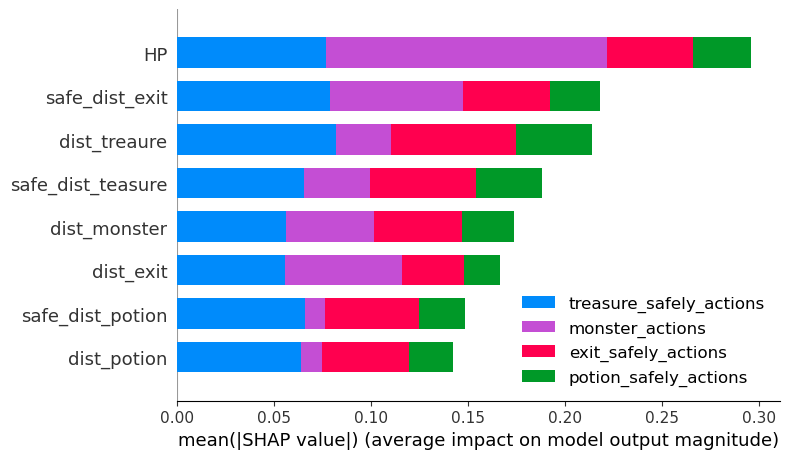

Dropdown(description='Select Label:', options=(('exit_safely_actions', 0), ('monster_actions', 1), ('potion_safely_actions', 2), ('treasure_safely_actions', 3)), value=0)


In [25]:
shap.summary_plot(shap_values = kernel_shap_values, feature_names=data[obs].columns, class_names=y_data.columns, plot_type='bar')
# shap.bar_plot(shap_values = kernel_shap_values, feature_names=data[obs].columns)
print(current_label)

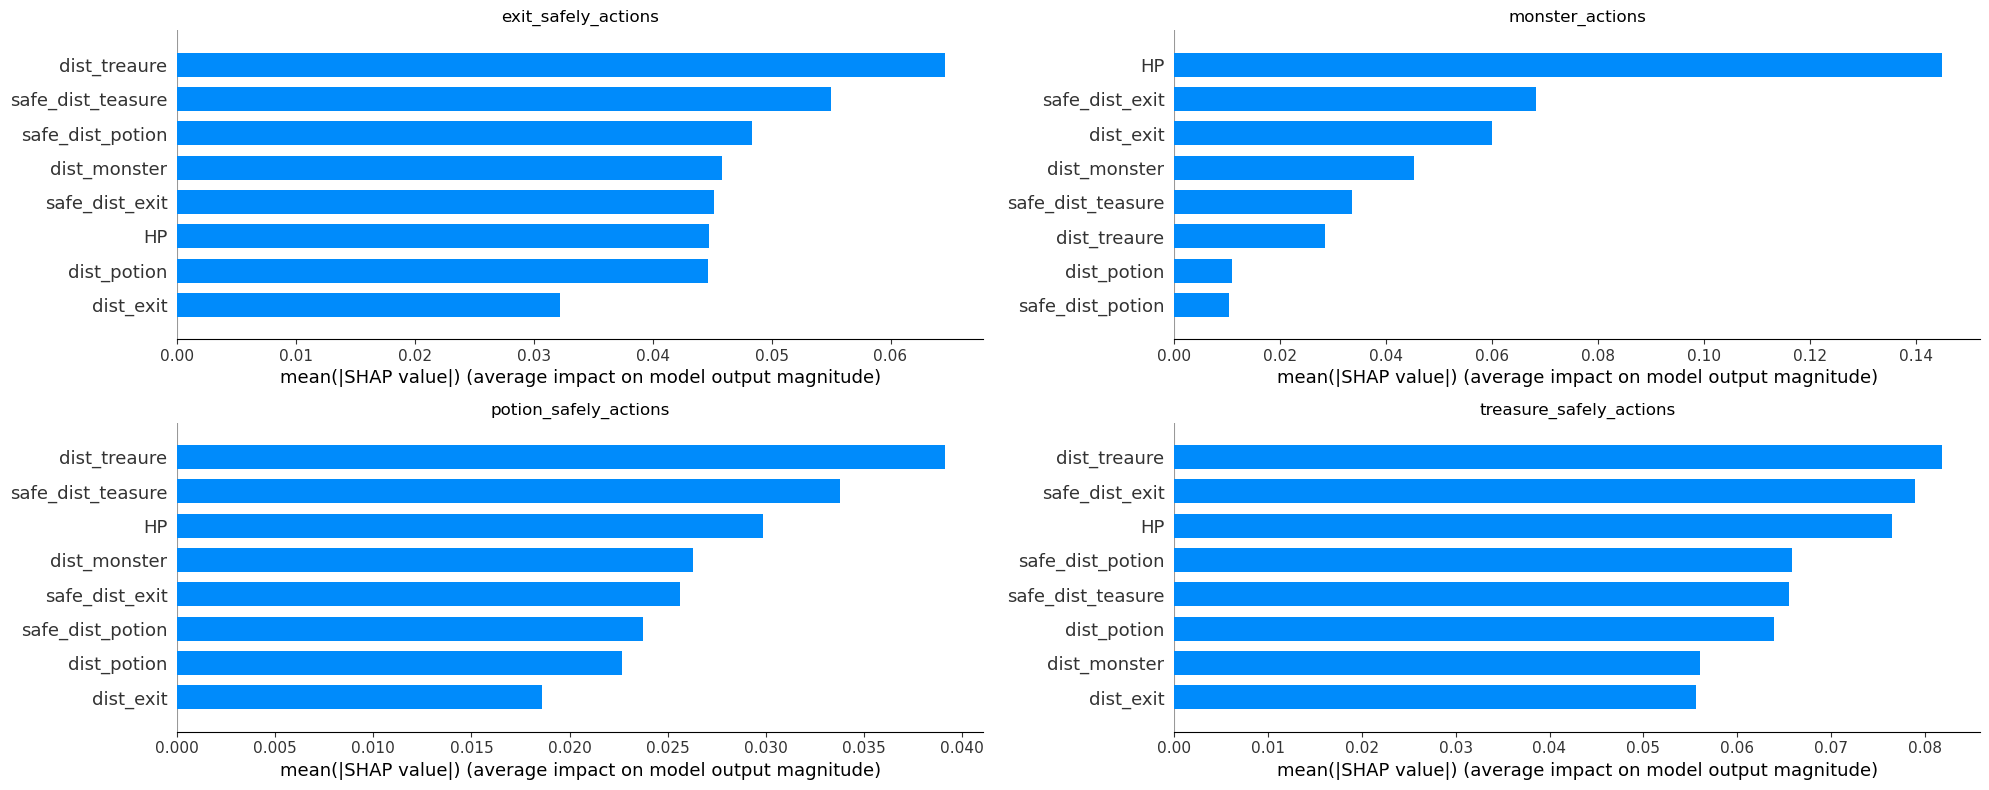

In [46]:
fig = plt.figure()
ax0 = fig.add_subplot(221)
ax0.title.set_text('exit_safely_actions')
shap.summary_plot(shap_values = kernel_shap_values[0], feature_names=data[obs].columns, class_names=y_data.columns, plot_type='bar',show=False)
ax1 = fig.add_subplot(222)
ax1.title.set_text('monster_actions')
shap.summary_plot(shap_values = kernel_shap_values[1], feature_names=data[obs].columns, class_names=y_data.columns, plot_type='bar', show= False)
ax2 = fig.add_subplot(223)
ax2.title.set_text('potion_safely_actions')
shap.summary_plot(shap_values = kernel_shap_values[2], feature_names=data[obs].columns, class_names=y_data.columns, plot_type='bar', show= False)
ax3 = fig.add_subplot(224)
ax3.title.set_text('treasure_safely_actions')
shap.summary_plot(shap_values = kernel_shap_values[3], feature_names=data[obs].columns, class_names=y_data.columns, plot_type='bar', show= False)
plt.gcf().set_size_inches(20,8)
plt.tight_layout() 
plt.show()

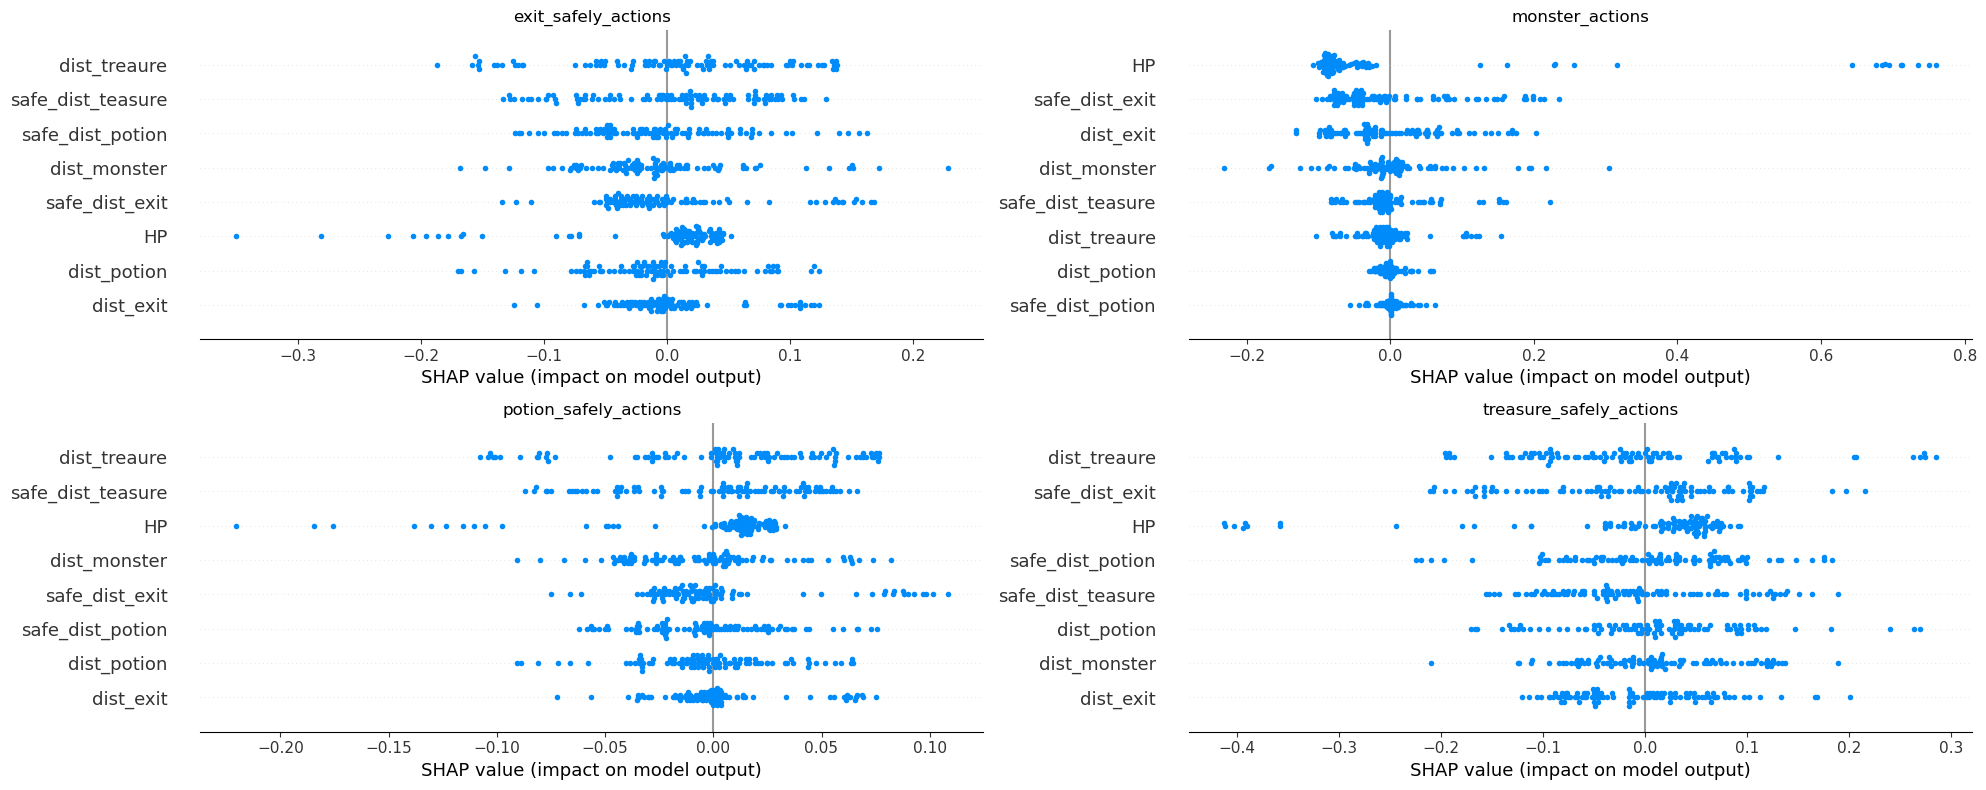

In [48]:
fig = plt.figure()
ax0 = fig.add_subplot(221)
ax0.title.set_text('exit_safely_actions')
shap.summary_plot(shap_values = kernel_shap_values[0], feature_names=data[obs].columns, class_names=y_data.columns,show=False)
ax1 = fig.add_subplot(222)
ax1.title.set_text('monster_actions')
shap.summary_plot(shap_values = kernel_shap_values[1], feature_names=data[obs].columns, class_names=y_data.columns, show= False)
ax2 = fig.add_subplot(223)
ax2.title.set_text('potion_safely_actions')
shap.summary_plot(shap_values = kernel_shap_values[2], feature_names=data[obs].columns, class_names=y_data.columns, show= False)
ax3 = fig.add_subplot(224)
ax3.title.set_text('treasure_safely_actions')
shap.summary_plot(shap_values = kernel_shap_values[3], feature_names=data[obs].columns, class_names=y_data.columns, show= False)
plt.gcf().set_size_inches(20,8)
plt.tight_layout() 
plt.show()


In [72]:
# shap.force_plot(Kernel_explainer.expected_value[0],kernel_shap_values[0][1],data[obs].iloc[1])
shap.force_plot(Kernel_explainer.expected_value[0],kernel_shap_values[0][15],data[obs].iloc[15])


In [73]:
data.iloc[15]

dist_monster                            10.0
dist_treaure                             6.0
safe_dist_teasure                        6.0
dist_potion                              8.0
safe_dist_potion                         8.0
dist_exit                               13.0
safe_dist_exit                          13.0
HP                                      30.0
play_style           treasure_safely_actions
Name: 15, dtype: object